In [3]:
import random
import numpy
import pandas as pd
import numpy as np
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
#from scoop import futures
import hashlib
import os
from numba import njit
from scipy.optimize import minimize
from scipy import optimize

In [2]:
!pip install deap

In [18]:
data_read=r"family_data.csv"

In [19]:
data=pd.read_csv(data_read, index_col='family_id')

In [20]:
data

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4
...,...,...,...,...,...,...,...,...,...,...,...
4995,16,1,66,33,18,70,56,46,86,60,4
4996,88,66,20,17,26,54,81,91,59,48,2
4997,32,66,54,17,27,21,74,81,3,7,6


In [21]:
data['n_people'].value_counts()

4    1451
3     981
5     899
2     717
6     494
7     301
8     157
Name: n_people, dtype: int64

In [22]:
# Probem COnstants
N_DAYS        = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125
FAMINY_SIZE   = 5000
DAYS          = list(range(N_DAYS,0,-1))

In [24]:
# Load util variables
family_size_dict  = data[['n_people']].to_dict()['n_people']
cols              = [f'choice_{i}' for i in range(10)]
choice_dict       = data[cols].T.to_dict()

# from 100 to 1
family_size_ls  = list(family_size_dict.values())
choice_dict_num = [{vv:i for i, vv in enumerate(di.values())} for di in choice_dict.values()]

# Computer penalities in a list
penalties_dict = {
  n: [
      0,
      50,
      50  + 9 * n,
      100 + 9 * n,
      200 + 9 * n,
      200 + 18 * n,
      300 + 18 * n,
      300 + 36 * n,
      400 + 36 * n,
      500 + 36 * n + 199 * n,
      500 + 36 * n + 398 * n
  ]
  for n in range(max(family_size_dict.values())+1)
}

In [25]:
# Create a Tollbox Optmizer

# The creator is a class factory that can build new classes at run-time. It will be called with first the desired name of the new class, 
# second the base class it will inherit, and in addition any subsequent arguments you want to become attributes of your class. 
# This allows us to build new and complex structures of any type of container from lists to n-ary trees.
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Now we will use our custom classes to create types representing our individuals as well as our whole population.
toolbox = base.Toolbox()

In [26]:
# Attribute generator
toolbox.register("attr_int",   random.randint, 1, 100)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, FAMINY_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

pop   = toolbox.population(n=1000)

print(pop[0])
print("len: ", len(pop))

[33, 97, 73, 39, 97, 87, 29, 54, 15, 7, 100, 99, 17, 80, 88, 19, 45, 100, 57, 62, 30, 34, 91, 23, 50, 91, 21, 61, 75, 58, 11, 95, 78, 30, 61, 44, 71, 7, 69, 20, 38, 95, 96, 66, 94, 56, 19, 88, 98, 81, 54, 56, 100, 66, 72, 71, 77, 30, 38, 47, 58, 56, 37, 69, 28, 73, 10, 55, 5, 65, 13, 85, 94, 61, 88, 35, 16, 97, 26, 3, 38, 70, 26, 1, 35, 100, 9, 69, 82, 66, 56, 35, 54, 72, 32, 75, 68, 94, 89, 47, 94, 88, 62, 9, 95, 16, 4, 33, 70, 23, 72, 81, 95, 37, 36, 49, 40, 14, 65, 43, 8, 11, 31, 40, 49, 61, 97, 51, 6, 77, 69, 60, 88, 89, 89, 41, 64, 89, 51, 72, 74, 78, 52, 80, 77, 26, 90, 34, 16, 23, 96, 1, 37, 72, 56, 10, 90, 84, 65, 57, 63, 60, 53, 81, 9, 46, 2, 76, 28, 4, 75, 82, 5, 24, 68, 26, 80, 43, 45, 72, 57, 21, 91, 31, 20, 80, 5, 14, 98, 13, 19, 41, 62, 37, 71, 41, 11, 82, 21, 27, 74, 91, 81, 81, 71, 26, 23, 61, 92, 77, 83, 37, 16, 100, 97, 44, 20, 17, 17, 63, 84, 27, 68, 87, 20, 29, 12, 89, 77, 6, 50, 82, 89, 26, 84, 47, 67, 94, 38, 64, 75, 59, 85, 83, 79, 27, 19, 47, 85, 56, 70, 44, 56,

In [27]:

# The evaluation function is pretty simple in our example. We just need to count the number of ones in an individual.
def cost_function(prediction, family_size_ls, choice_dict, choice_dict_num, penalties_dict):
    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in DAYS}
    
    # Looping over each family; d is the day, n is size of that family, 
    # and choice is their top choices
    for n, c, c_dict, choice in zip(family_size_ls, prediction, list(choice_dict.values()), choice_dict_num):
        d = int(c)
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d not in choice:
            penalty += penalties_dict[n][-1]
        else:
            penalty += penalties_dict[n][choice[d]]

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    k = 0
    for v in daily_occupancy.values():
        if (v > MAX_OCCUPANCY):
            k = k + (v - MAX_OCCUPANCY)
        if (v < MIN_OCCUPANCY):
            k = k + (MIN_OCCUPANCY - v)
    #    if k > 0:
    #        penalty += 100000000 
    penalty += 100000*k

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[DAYS[0]]-125.0) / 400.0 * daily_occupancy[DAYS[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[DAYS[0]]
    for day in DAYS[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    penalty += accounting_cost

    return (penalty, )

In [28]:
toolbox.register("evaluate",   cost_function, family_size_ls=family_size_ls, choice_dict=choice_dict, 
                                                 choice_dict_num=choice_dict_num, penalties_dict=penalties_dict)
toolbox.register("mate",       tools.cxUniform, indpb=0.5)
toolbox.register("select",     tools.selTournament, tournsize=10) 
toolbox.register("mutate",     tools.mutShuffleIndexes, indpb=0.5)

In [29]:
ngen      = 100  # Gerations
npop      = 1000 # Population

hof   = tools.ParetoFront()
stats = tools.Statistics(lambda ind: ind.fitness.values)

# Statistics
stats.register("avg", numpy.mean, axis=0)
stats.register("std", numpy.std, axis=0)
stats.register("min", numpy.min, axis=0)
stats.register("max", numpy.max, axis=0)


# Evolution
pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=npop, lambda_=npop,
                                          cxpb=0.7,   mutpb=0.3, ngen=ngen, 
                                          stats=stats, halloffame=hof)

gen	nevals	avg             	std             	min                	max             
0  	1000  	[5.07253913e+08]	[8.50092927e+09]	[10629721.29543671]	[2.47747305e+11]
1  	1000  	[11059133.33741139]	[321480.51047199]	[10629721.29543671]	[13559422.10678999]
2  	1000  	[10776918.82348411]	[78540.0620847]  	[10629721.29543671]	[11062923.68268762]
3  	1000  	[10687992.38184763]	[35602.84322784] 	[10606774.49254279]	[10851999.35494885]
4  	1000  	[10647245.89510322]	[20989.3038983]  	[10592140.51094391]	[10708579.7622586] 
5  	1000  	[10622249.27575645]	[15735.74604736] 	[10567387.92569911]	[10655002.98434259]
6  	1000  	[10601186.03576681]	[17297.96344113] 	[10532517.66415574]	[10642313.51181724]
7  	1000  	[10580931.43478535]	[19555.95718448] 	[10505501.74004431]	[10627113.17053921]
8  	1000  	[10555692.68848958]	[22086.14325535] 	[10503201.26712025]	[10595711.91493214]
9  	1000  	[10530163.25231017]	[13071.96631249] 	[10490380.31460858]	[10578623.14304858]
10 	1000  	[10514046.6748187] 	[148

In [30]:
# Best Solution
best_solution = tools.selBest(pop, 1)[0]
print("")
print("[{}] best_score: {}".format(logbook[-1]['gen'], logbook[-1]['min'][0]))


[100] best_score: 9246579.354118543


In [52]:
for i in range(11):
    print("iteration : [{}] , score: {}".format(logbook[i*10]['gen'], round(logbook[i*10]['min'][0]),3))

iteration : [0] , score: 10629721
iteration : [10] , score: 10433301
iteration : [20] , score: 10228604
iteration : [30] , score: 9986882
iteration : [40] , score: 9789790
iteration : [50] , score: 9600649
iteration : [60] , score: 9460435
iteration : [70] , score: 9341504
iteration : [80] , score: 9281734
iteration : [90] , score: 9252413
iteration : [100] , score: 9246579


2024-05-03 15:23:35,688 [48812] WARNING  py.warnings:109: [JupyterRequire] C:\Users\HP\AppData\Local\Temp/ipykernel_48812/3204590643.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(front[:,0][1:-1], front[:,1][1:-1], "-bo", c="y")



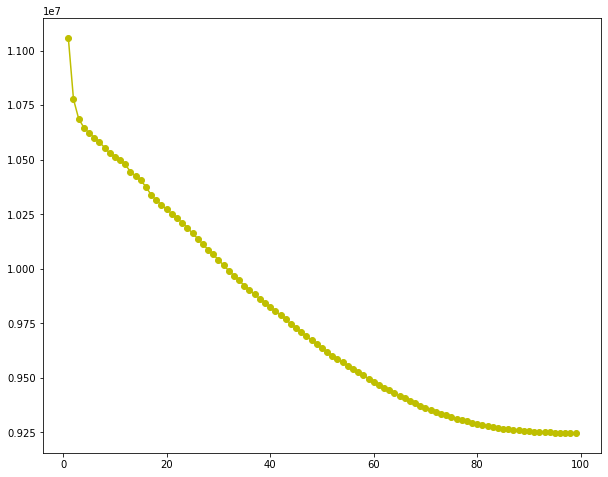

In [35]:
# History AVG
plt.figure(figsize=(10,8))
front = np.array([(c['gen'], c['avg'][0]) for c in logbook])
plt.plot(front[:,0][1:-1], front[:,1][1:-1], "-bo", c="y")
plt.axis("tight")
plt.show()

In [37]:
import plotly.graph_objects as go

# Extracting data
front = np.array([(c['gen'], c['avg'][0]) for c in logbook])

# Creating Plotly figure
fig = go.Figure()

# Adding trace
fig.add_trace(go.Scatter(
    x=front[:,0][1:-1],
    y=front[:,1][1:-1],
    mode='markers+lines',
    marker=dict(color='yellow', size=8),
    line=dict(color='blue', width=2),
    name='Cost'
))

# Updating layout
fig.update_layout(
    title='Cost Function plot along Generations of iterations',
    xaxis_title='Generation',
    yaxis_title='Average Fittness of Cost function',
    showlegend=True
)

# Show plot
fig.show()